In [57]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ploidex import *
import igv_notebook

## 1) Loading the allele-specific count data 

First we load in the allele-specific counts for our 8 samples (IsoSeq from 4 x potato tubers, 4 x potato leaves). We also have some metadata that links the gene ids from the alleles of a gene together with "Synt_ids" and we have some information about the allele lengths that we use for quality control.

In [2]:
# Metadata for genes
var_obs_file = "/scratch/nadjafn/potato-allelic-orthogroups/output_atlantic/07_SYNTELOG_SIMILARITY/ATL_v3.hc_gene_models.repr_blast_syntelog_blast_analysis.tsv"
# directory of gene counts from minimap2
gene_counts_dir = "/scratch/nadjafn/Atlantic_ASE/polyploid-allele-exp/results/03_GENECOUNTS"
# Define sample IDs and their conditions
sample_info = {
    "SRR14993892": "leaf",
    "SRR14993893": "leaf", 
    "SRR14993894": "leaf",
    "SRR14993895": "leaf",
    "SRR14996168": "leaf",
    "SRR14995031": "tuber",
    "SRR14995032": "tuber",
    "SRR14995033": "tuber",
    "SRR14995034": "tuber",
    "SRR14995933": "tuber",
}

# Load the data into an AnnData object
allelic_data = load_ase_data(
    var_obs_file=var_obs_file,
    gene_counts_dir=gene_counts_dir,
    sample_info=sample_info, fillna=0)

### Task 1: look at the information of each transcript id and the grouping of alleles

In [ ]:
allelic_data.var
#  remove the NaN rows

# rename Synt_id to gene_id

# more text to explain

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch
transcript_id,,,,,,
Soltu.Atl_v3.06_2G013790.1,NaN,NaN,NaN,NaN,NaN,NaN
Soltu.Atl_v3.01_2G036600.1,Synt_id_6024,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN
Soltu.Atl_v3.09_0G013460.1,NaN,NaN,NaN,NaN,NaN,NaN
Soltu.Atl_v3.02_3G008660.1,Synt_id_6995,0hap1_0hap2_1hap3_1hap4_s,NaN,NaN,NaN,NaN
Soltu.Atl_v3.04_4G019190.2,Synt_id_14369,1hap1_1hap2_1hap3_1hap4_s,2G,less_1%_difference,NaN,NaN
...,...,...,...,...,...,...
Soltu.Atl_v3.12_0G007550.1,NaN,NaN,NaN,NaN,NaN,NaN
Soltu.Atl_v3.09_0G014070.1,NaN,NaN,NaN,NaN,NaN,NaN
Soltu.Atl_v3.S159640.1,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
allelic_data.layers['unique_counts']

array([[ 72.,   1.,  11., ...,   0.,   0.,   0.],
       [ 43.,   0.,   9., ...,   0.,   0.,   0.],
       [373.,   0.,  64., ...,   0.,   0.,   0.],
       ...,
       [248.,   1.,  31., ...,   1.,   0.,   0.],
       [158.,   0.,  18., ...,   0.,   0.,   0.],
       [153.,   0.,  20., ...,   0.,   1.,   1.]], shape=(10, 1369))

Data table rows are different genes

In [4]:
allelic_data.obs

,condition
SRR14993892,leaf
SRR14993893,leaf
SRR14993894,leaf
SRR14993895,leaf
SRR14996168,leaf
SRR14995031,tuber
SRR14995032,tuber
SRR14995033,tuber
SRR14995034,tuber
SRR14995933,tuber


### Metadata
* Synt_id: links together the transcript ids from the same gene on the different haplotypes 
* synteny category: type of allele group (e.g 1hap1_1hap2_1hap3_1hap4_s: on each haplotype 1 copy of the gene)

# 2) Quality Control

We first need to check if the allelic counts are okay. 
We will also remove genes with low expression.

## Filter genenes with low expression

We filter Syntelog groups that don't have a min expression. This function can also be used to filter for gene_id expression or similar

In [ ]:
allelic_data = filter_low_expression(allelic_data, min_expression=50, group_col= 'Synt_id', mode= 'all')

# maybe normalize the data between different samples; filter based on lib size, maybe TPM

# maybe lower

Filtered out 0 groups
Kept 1369 / 1369 items


## Calculate allelic ratios

To see if there is bias 

In [63]:
allelic_data = calculate_allelic_ratios(allelic_data , 'unique_counts')
allelic_data = calculate_multi_ratios(allelic_data, 'unique_counts', 'ambiguous_counts')

In [52]:
allelic_data.layers['unique_counts']

array([[ 72.,   1.,  11., ...,   0.,   0.,   0.],
       [ 43.,   0.,   9., ...,   0.,   0.,   0.],
       [373.,   0.,  64., ...,   0.,   0.,   0.],
       ...,
       [248.,   1.,  31., ...,   1.,   0.,   0.],
       [158.,   0.,  18., ...,   0.,   0.,   0.],
       [153.,   0.,  20., ...,   0.,   1.,   1.]], shape=(10, 1369))

In [66]:
allelic_data.layers["allelic_ratio_unique_counts"]

array([[0.22929936, 0.00515464, 0.05729167, ..., 0.        , 0.        ,
        0.        ],
       [0.26708075, 0.        , 0.08653846, ..., 0.        , 0.        ,
        0.        ],
       [0.22911548, 0.        , 0.06406406, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.27802691, 0.00653595, 0.10763889, ..., 0.00240385, 0.        ,
        0.        ],
       [0.29811321, 0.        , 0.11612903, ..., 0.        , 0.        ,
        0.        ],
       [0.30417495, 0.        , 0.08583691, ..., 0.        , 0.00066401,
        0.0075188 ]], shape=(10, 1369))

In [ ]:
allelic_data.var

mulitmapping ratio = number of ambiguous counts / number of total (unique + ambiguous counts)

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch,multimapping_ratio
transcript_id,,,,,,,
Soltu.Atl_v3.04_3G005900.1,Synt_id_1846,1hap1_1hap2_3hap3_1hap4_no_s,NaN,NaN,NaN,NaN,0.015955
Soltu.Atl_v3.03_4G019300.1,Synt_id_11647,1hap1_1hap2_1hap3_2hap4_no_s,NaN,NaN,NaN,NaN,0.042925
Soltu.Atl_v3.11_4G002060.2,Synt_id_856,1hap1_3hap2_2hap3_1hap4_no_s,NaN,NaN,NaN,NaN,0.094961
Soltu.Atl_v3.09_1G011820.2,Synt_id_25421,1hap1_1hap2_1hap3_1hap4_s,equal_lengths,less_1%_difference,SNPs,17.0,0.030495
Soltu.Atl_v3.03_4G019160.1,Synt_id_11631,1hap1_1hap2_1hap3_1hap4_s,equal_lengths,less_1%_difference,SNPs,17.0,0.033361
...,...,...,...,...,...,...,...
Soltu.Atl_v3.09_3G022860.1,Synt_id_2554,1hap1_1hap2_5hap3_2hap4_no_s,NaN,NaN,NaN,NaN,0.031229
Soltu.Atl_v3.03_3G019310.1,Synt_id_10746,1hap1_1hap2_2hap3_1hap4_no_s,NaN,NaN,NaN,NaN,0.008187
Soltu.Atl_v3.02_4G005110.1,Synt_id_2028,5hap1_1hap2_3hap3_8hap4_no_s,NaN,NaN,NaN,NaN,0.163357


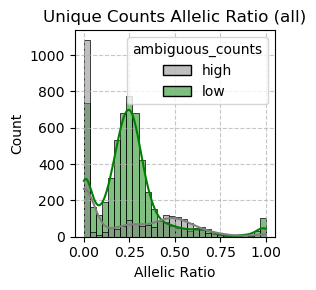

In [8]:
plot_allelic_ratios(
    allelic_data,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

We observe that some genes have high bias towards one allele ('allelic_ratio_unique_counts' > 0.8). We can inspect these genes to see if there are any mistakes. In the next plot we will only look at genes that have the same CDS length for all allels

And genes with high bias should be gone. If there are still genes that have high allelic ratios and now mulitmapping reads we can extract them and analyze them in Jbrowse or similar 

In [48]:
high_bias = allelic_data[:,(allelic_data .var['multimapping_ratio'] < 0.25) & (allelic_data .layers['allelic_ratio_unique_counts'] > 0.6).all(axis=0) & (allelic_data .var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")]# & (test_ad.obsm["CDS_haplotype_with_longest_annotation"] == "equal_lengths") ]
high_bias.var.head()

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch,multimapping_ratio
transcript_id,,,,,,,
Soltu.Atl_v3.08_1G011030.1,Synt_id_22948,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.066812
Soltu.Atl_v3.02_1G001420.1,Synt_id_6413,1hap1_1hap2_1hap3_1hap4_s,3G,more_20%_difference,NaN,NaN,0.034742
Soltu.Atl_v3.01_1G001670.1,Synt_id_2924,1hap1_1hap2_1hap3_1hap4_s,2G,more_20%_difference,NaN,NaN,0.036542
Soltu.Atl_v3.12_4G009770.1,Synt_id_31509,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.000434
Soltu.Atl_v3.03_3G029270.1,Synt_id_11726,1hap1_1hap2_1hap3_1hap4_s,1G,more_1%_difference,NaN,NaN,0.029719


Now we want to look at one of these genes with high bias in more detail. First we look at the allelic ratios to see which of the alleles has the highest expression

In [10]:
allelic_data [:,allelic_data .var["Synt_id"] == "Synt_id_12702"].layers['allelic_ratio_unique_counts']

ArrayView([[0.08923077, 0.07692308, 0.12615385, 0.70769231],
           [0.14130435, 0.07065217, 0.1576087 , 0.63043478],
           [0.08190925, 0.09487331, 0.11785504, 0.7053624 ],
           [0.10810811, 0.07657658, 0.11711712, 0.6981982 ],
           [0.07935285, 0.07935285, 0.09090909, 0.75038521],
           [0.0916129 , 0.08      , 0.12387097, 0.70451613],
           [0.06563707, 0.04826255, 0.12162162, 0.76447876],
           [0.07142857, 0.06157635, 0.14901478, 0.7179803 ],
           [0.13461538, 0.0534188 , 0.20940171, 0.6025641 ],
           [0.07557118, 0.05623902, 0.13532513, 0.73286467]])

The rows are the replicates and the columns are the alleic ratios for alleles

In [11]:
allelic_data[:,allelic_data .var["Synt_id"] == "Synt_id_12702"].var

,Synt_id,synteny_category,CDS_haplotype_with_longest_annotation,CDS_length_category,mismatch_category,mismatch,multimapping_ratio
transcript_id,,,,,,,
Soltu.Atl_v3.04_4G002730.2,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548
Soltu.Atl_v3.04_2G002760.1,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548
Soltu.Atl_v3.04_3G002920.1,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548
Soltu.Atl_v3.04_1G003230.1,Synt_id_12702,1hap1_1hap2_1hap3_1hap4_s,1G,more_20%_difference,NaN,NaN,0.032548


Which of the alleles is the longest in the annotation? And which one with the highest allelic ratio?

Lets also look at the annotation in the [genome browser](https://spuddb.uga.edu/jb2/?session=share-Q7AqVFDKBg&password=OioEy) 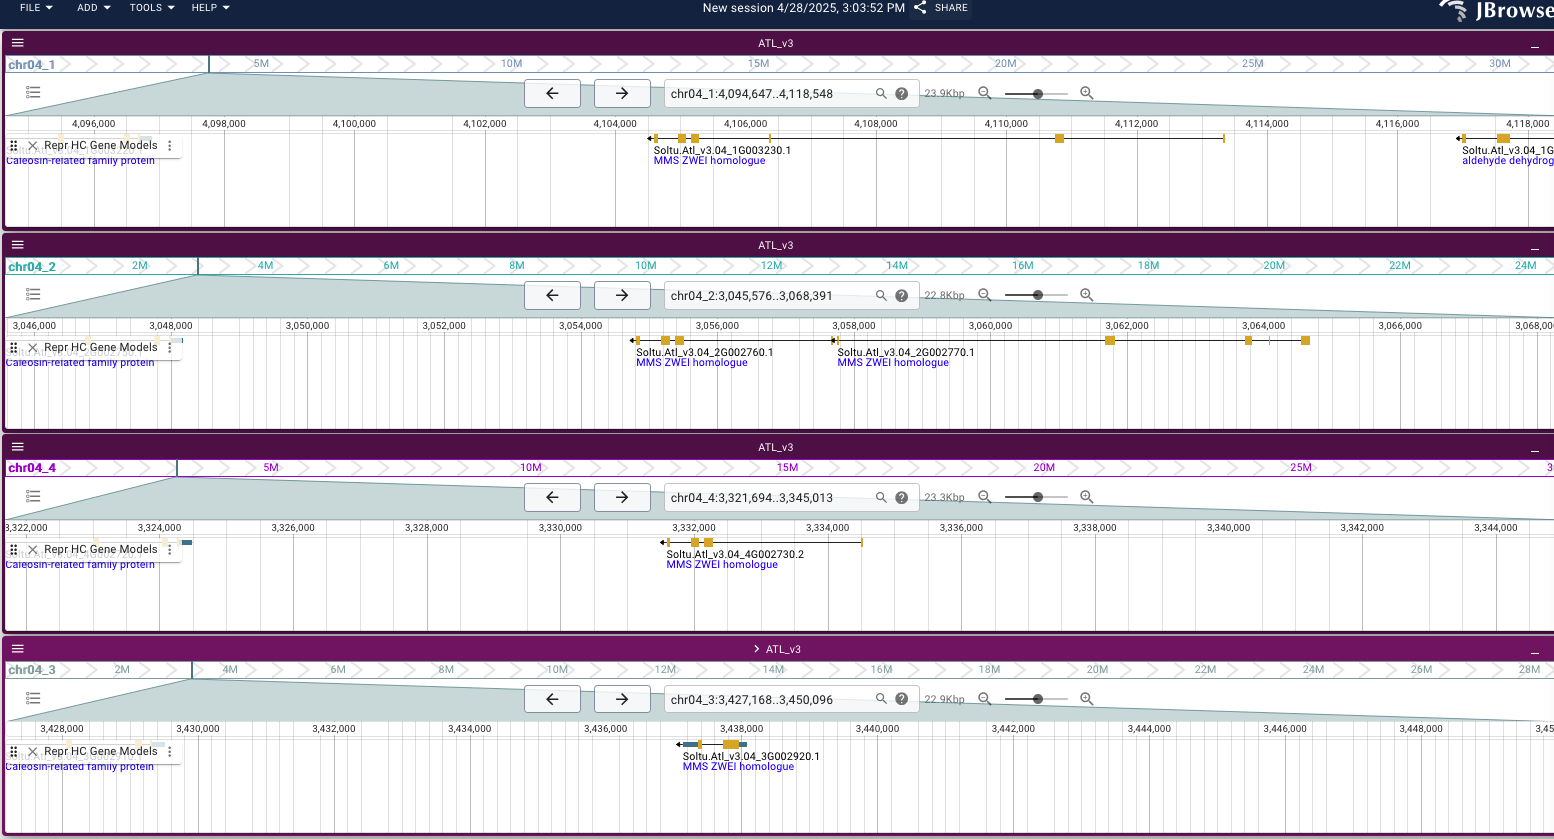

Should we compare the expression of these alleles?

## Alleles with same CDS length

To avoid annotation errors to bias the results, we will only look at alleles that have the same length on all haplotypes


https://spuddb.uga.edu/jb2/?session=share-XWreWcRKES&password=cAo2R

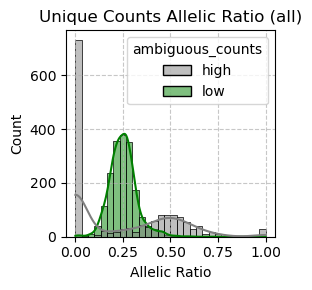

In [13]:
# filter transcripts that are not equal lengths
mask = allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths"
allelic_data_length_filter = allelic_data[:,mask].copy()
plot_allelic_ratios(
    allelic_data_length_filter,
    synteny_category="1hap1_1hap2_1hap3_1hap4_s", 
    sample='all', 
    ratio_type="unique",
    figsize = (3,3),
    kde = True,
    multimapping_threshold=0.25
)

# 3) Testing for allelic imbalance

Now that we have the count per allele and filtered genes that could be biased by high number of ambgious reads and length differences, we want to test if there are genens that have unbalanced allelic expression (> or < than 0.25)

Found 11 from 46 syntelogs with at least one significantly different allele (FDR < 0.05 and ratio difference > 0.1)


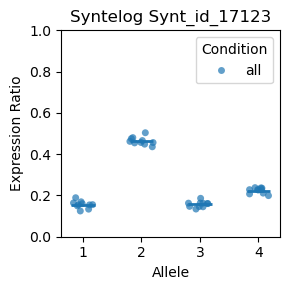

In [49]:
# select only the genes with equal lengths, low multimapping ratio and synteny category "1hap1_1hap2_1hap3_1hap4_s"
mask = (allelic_data.var["CDS_haplotype_with_longest_annotation"] == "equal_lengths" ) & (allelic_data.var["multimapping_ratio"] < 0.25) & (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_length_filter = allelic_data[:,mask].copy()

# 1. Test for differential allelic ratios withing conditions
results = test_allelic_ratios_within_conditions(allelic_data_length_filter, layer="unique_counts", test_condition= "all", inplace=True)

# 2. Get top differential syntelogs
top_results = get_top_differential_syntelogs(results, n=1, sort_by='FDR', fdr_threshold=0.005, ratio_threshold=0.1)

# 3. Plot the results
fig = plot_top_differential_syntelogs(top_results, figsize=(3, 3), sort_by='ratio_difference')
plt.show()

Lets look at the gene with "Synt_id_17123" in more detail:

In [16]:
top_results[top_results["Synt_id"] == "Synt_id_17123"]

,Synt_id,allele,transcript_id,p_value,ratio_difference,n_alleles,ratios_all_mean,ratios_rep_all,FDR
47,Synt_id_17123,2,Soltu.Atl_v3.06_2G000620.2,1.513009e-19,0.213734,4,0.463918,"[0.4659248956884562, 0.4356955380577428, 0.456...",2.783936e-17
45,Synt_id_17123,3,Soltu.Atl_v3.06_3G000610.3,5.594163e-14,0.090575,4,0.159608,"[0.1627260083449235, 0.14698162729658792, 0.16...",3.431087e-12
46,Synt_id_17123,1,Soltu.Atl_v3.06_1G000450.1,1.204756e-13,0.094952,4,0.155231,"[0.13351877607788595, 0.1889763779527559, 0.15...",5.541876e-12
44,Synt_id_17123,4,Soltu.Atl_v3.06_4G000620.1,1.473346e-04,0.028726,4,0.221457,"[0.23783031988873435, 0.2283464566929134, 0.22...",3.475584e-04


Lets look at the expression for these alleles in the genome Browser https://spuddb.uga.edu/jb2/?session=share-y51Gk46x4-&password=RWDWO

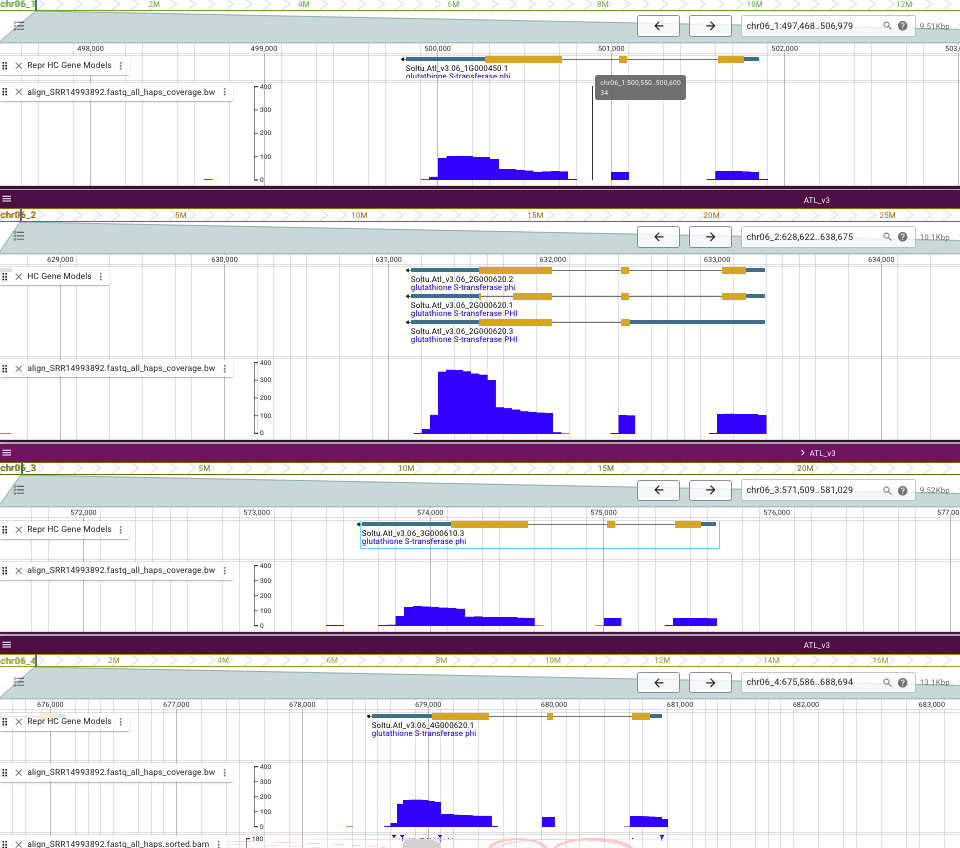

Why is the allele 2 of gluthadione S-transferase hihger expressed than the other alleles?

## Cis reulatory element? Promotor analysis?

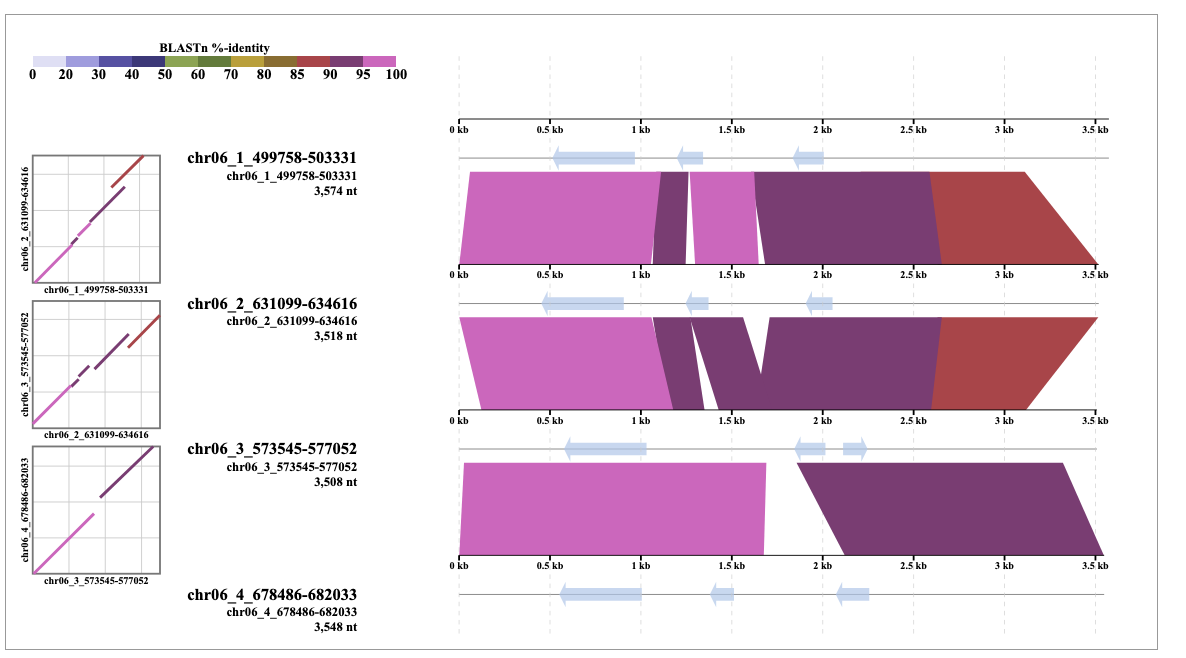

https://www.genome.jp/digalign/u/53kR88J_Pi7hkta3z3hB_w/aln/chr06_1_499758-503331/chr06_2_631099-634616/chr06_3_573545-577052/chr06_4_678486-682033

# 4) Testing for differential allele usage between tuber and leave

Now we can also test if between the two conditions (tuber and leaf) the allelic expression changes. E.g is there a dominant allele in tuber that is not expressed in leaf?

In [68]:
# Filter to only include synteny category "1hap1_1hap2_1hap3_1hap4_s" 
mask = (allelic_data.var["synteny_category"] == "1hap1_1hap2_1hap3_1hap4_s")
allelic_data_group_filter = allelic_data[:,mask].copy()

Why are we not filtering the allels with high multimapping ratios or unqual lengths?

Found 49 from 88 syntelogs with at least one significantly different allelic ratio (FDR < 0.05)


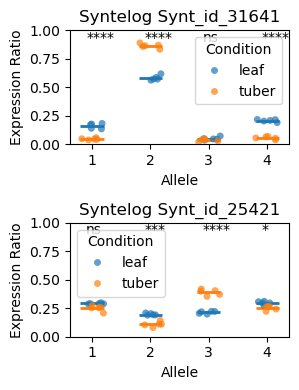

In [69]:
# 1. Run allelic ratio test
results_df_trans = test_allelic_ratios_between_conditions(allelic_data_group_filter)

# 2. Get top differential syntelogs
top_results_trans = get_top_differential_syntelogs(results_df_trans, n=2, sort_by='FDR', fdr_threshold=0.05)

# 3. Plot the results
fig = plot_top_differential_syntelogs(top_results_trans, figsize=(3, 4), sort_by='FDR')
plt.show()



https://spuddb.uga.edu/jb2/?session=share-3b8nGq87AT&password=R8aAc

In [70]:
top_results_trans[top_results_trans["Synt_id"] == "Synt_id_31641"]

,Synt_id,allele,transcript_id,p_value,ratio_difference,n_alleles,ratios_leaf_mean,ratios_rep_leaf,ratios_tuber_mean,ratios_rep_tuber,FDR
234,Synt_id_31641,2,Soltu.Atl_v3.12_2G022830.3,4.984393e-09,0.277184,4,0.584637,"[0.5723502304147465, 0.5620689655172414, 0.571...",0.861821,"[0.8341056533827618, 0.8583815028901735, 0.864...",0.000002
233,Synt_id_31641,4,Soltu.Atl_v3.12_4G010920.1,9.283375e-09,0.149927,4,0.206378,"[0.20921658986175115, 0.21724137931034482, 0.2...",0.056451,"[0.0685820203892493, 0.06502890173410404, 0.05...",0.000002
235,Synt_id_31641,1,Soltu.Atl_v3.12_1G007860.2,1.605588e-07,0.114335,4,0.159575,"[0.1824884792626728, 0.1724137931034483, 0.139...",0.045240,"[0.04819277108433735, 0.03757225433526012, 0.0...",0.000007
236,Synt_id_31641,3,Soltu.Atl_v3.12_3G021510.8,2.196968e-01,0.013557,4,0.050078,"[0.035944700460829496, 0.04827586206896552, 0....",0.036521,"[0.04911955514365153, 0.03901734104046243, 0.0...",0.440631


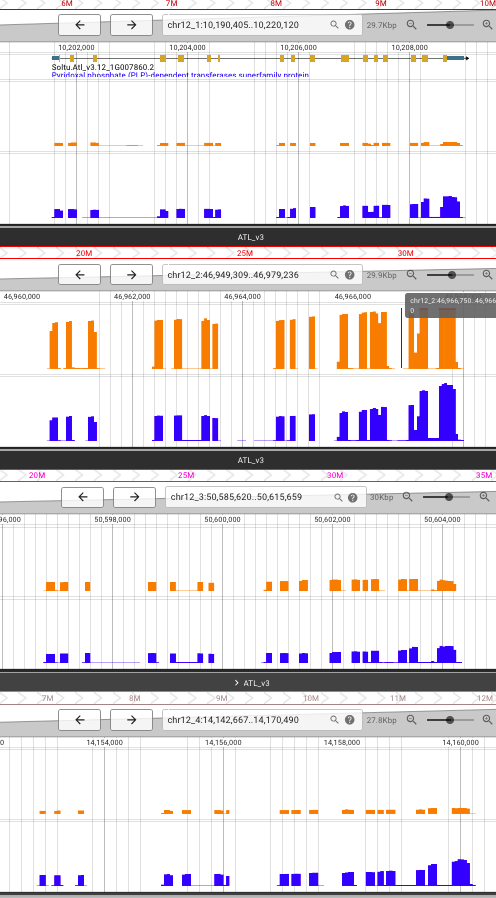

https://spuddb.uga.edu/jb2/?session=local-7vzorxQDd9kfw8i1oFRMz

In [71]:
# Create PCA components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(my_ad.layers["unique_counts"].T)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'],
    index=my_ad.var_names  # Add this line to set the correct index
)

# Add condition directly from var
principalDf['condition'] = my_ad.var["condition"]
finalDf = principalDf

NameError: name 'my_ad' is not defined

## Make a PCA plot to vizualize the samples

In [ ]:
# split into haplotypes 
# Create PCA components
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(my_ad.layers["unique_counts"].T)
principalDf = pd.DataFrame(
    data=principalComponents,
    columns=['principal component 1', 'principal component 2'],
    index=my_ad.var_names  # Add this line to set the correct index
)

# Add condition directly from var
principalDf['condition'] = my_ad.var["condition"]
finalDf = principalDf


fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 15)

targets = ['leaf', 'tuber']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['condition'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Visualization

In [ ]:
igv_notebook.init()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>